In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/ResidentPatient075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-01 10:09:11 - INFO - 1879249399.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/ResidentPatient075/03/log.log', param_file='saved_models/kgc/ResidentPatient075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/ResidentPatient075/03/checkpoint/', model_path='saved_models/kgc/ResidentPatient075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='ResidentPatient', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, 

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2023-01-01 10:09:11 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2023-01-01 10:09:11 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:09:11 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:09:11 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:09:11 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:09:11 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2023-01-01 10:09:11 - INFO - data_helper.py - 441 - ==========
2023-01-01 10:09:11 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:09:11 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:09:11 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:09:11 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:09:11 - INFO - data_helper.py - 443 - ==========
2023-01-01 10:09:11 - INFO - data_helper.py - 445 - entity_spec

13821 16962


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

In [14]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

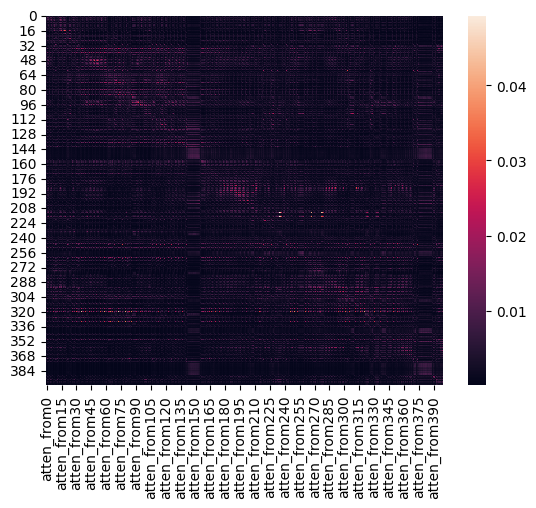

ResidentPatient:, ranking []


,predicate,whom,subject,why,what,where
0,word.predicate:kill,AllTitle:Holmes,AllTitle:Holmes,CrookedMan:Nancy,bos_e,AllTitle:Holmes
1,word.predicate:exist,ResidentPatient:Blessington,bos_e,ResidentPatient:Young_man,DevilsFoot:Owen,SilverBlaze:John_Straker
2,word.predicate:find,CrookedMan:Nancy,ResidentPatient:Young_man,DevilsFoot:Sterndale,SilverBlaze:Silver_Blaze,CrookedMan:Morrison
3,word.predicate:hit,ResidentPatient:Young_man,ResidentPatient:Blessington,word.predicate:exist,CrookedMan:Nancy,DevilsFoot:Owen
4,word.predicate:ask,DevilsFoot:Sterndale,CrookedMan:Nancy,DevilsFoot:Owen,AllTitle:Holmes,CrookedMan:Nancy
5,word.predicate:say,DancingMen:Cubitt,DevilsFoot:Sterndale,bos_e,word.predicate:exist,SilverBlaze:Silver_Blaze
6,word.predicate:have,DancingMen:Elsie,ResidentPatient:Elderly_man,AllTitle:Holmes,word.predicate:receive,ResidentPatient:Blessington
7,DevilsFoot:Sterndale,word.predicate:have,ResidentPatient:Percy_Trevelyan,word.predicate:putInto,CrookedMan:Barclay,ACaseOfIdentity:Woman
8,SilverBlaze:Night_of_the_incident,ResidentPatient:Percy_Trevelyan,DancingMen:Cubitt,CrookedMan:police,ResidentPatient:Young_man,word.predicate:love
9,CrookedMan:Nancy,ACaseOfIdentity:Hosmer,word.predicate:have,SilverBlaze:two_young_men,SilverBlaze:John_Straker,DevilsFoot:Brenda


380

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:247']

,head,relation,tail,atten_from380
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.010633
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.010051
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.009691
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.009485
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.009374
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.009078
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008923
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008645
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.008540
89,ResidentPatient:182,kgc:what,ResidentPatient:185,0.008257


----------


381

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:248']

,head,relation,tail,atten_from381
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.010072
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.009520
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.009447
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.009109
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.008611
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.008511
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008417
135,ResidentPatient:192,kgc:what,ResidentPatient:193,0.008329
56,ResidentPatient:175,kgc:what,ResidentPatient:Pistol,0.007989
121,ResidentPatient:188,kgc:what,ResidentPatient:189,0.007765


----------


382

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:249']

,head,relation,tail,atten_from382
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.010893
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.010594
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.009907
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.009567
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.009485
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.009310
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.008838
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008351
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.008346
379,ResidentPatient:242,kgc:what,ResidentPatient:246,0.008216


----------


383

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:250']

,head,relation,tail,atten_from383
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.011530
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.011473
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.009832
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.009558
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.008944
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008782
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008516
152,ResidentPatient:194,kgc:what,ResidentPatient:204,0.008415
151,ResidentPatient:194,kgc:what,ResidentPatient:203,0.008367
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.008218


----------


384

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:251']

,head,relation,tail,atten_from384
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.009950
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.009361
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.009062
135,ResidentPatient:192,kgc:what,ResidentPatient:193,0.008466
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.008024
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008010
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.007992
152,ResidentPatient:194,kgc:what,ResidentPatient:204,0.007226
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.007142
151,ResidentPatient:194,kgc:what,ResidentPatient:203,0.007077


----------


385

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:252']

,head,relation,tail,atten_from385
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.012221
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.010099
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.009990
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.009081
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.008943
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.008758
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.008666
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008659
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008568
93,ResidentPatient:183,kgc:what,ResidentPatient:Bank,0.008107


----------


386

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:253']

,head,relation,tail,atten_from386
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.010458
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.009644
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008760
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.008401
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008220
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.008136
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.008089
342,ResidentPatient:234,kgc:what,ResidentPatient:239,0.007827
89,ResidentPatient:182,kgc:what,ResidentPatient:185,0.007808
135,ResidentPatient:192,kgc:what,ResidentPatient:193,0.007798


----------


387

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:254']

,head,relation,tail,atten_from387
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.011936
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.011273
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.009973
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.009753
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.009542
93,ResidentPatient:183,kgc:what,ResidentPatient:Bank,0.008738
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008730
56,ResidentPatient:175,kgc:what,ResidentPatient:Pistol,0.008591
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.008519
387,ResidentPatient:242,kgc:what,ResidentPatient:254,0.008291


----------


388

['ResidentPatient:242', 'kgc:what', 'ResidentPatient:255']

,head,relation,tail,atten_from388
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.013729
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.011525
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.010822
56,ResidentPatient:175,kgc:what,ResidentPatient:Pistol,0.009908
139,ResidentPatient:193,kgc:what,ResidentPatient:fact,0.009314
93,ResidentPatient:183,kgc:what,ResidentPatient:Bank,0.009045
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.008842
60,ResidentPatient:176,kgc:what,ResidentPatient:Pistol,0.008709
346,ResidentPatient:235,kgc:what,ResidentPatient:screwdriver,0.008570
388,ResidentPatient:242,kgc:what,ResidentPatient:255,0.008490


----------


389

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from389
90,bos_e,bos_r,bos_e,0.005446
81,ResidentPatient:181,kgc:what,AllTitle:Holmes,0.005337
82,ResidentPatient:181,kgc:what,AllTitle:Watson,0.005306
53,bos_e,bos_r,bos_e,0.005089
140,bos_e,bos_r,bos_e,0.004982
94,bos_e,bos_r,bos_e,0.004902
84,bos_e,bos_r,bos_e,0.004818
343,bos_e,bos_r,bos_e,0.004761
42,bos_e,bos_r,bos_e,0.004753
38,bos_e,bos_r,bos_e,0.004742


----------


390

['ResidentPatient:243', 'kgc:subject', 'ResidentPatient:Cigar']

,head,relation,tail,atten_from390
390,ResidentPatient:243,kgc:subject,ResidentPatient:Cigar,0.018860
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.011701
189,ResidentPatient:203,kgc:subject,ResidentPatient:invader,0.011538
358,ResidentPatient:238,kgc:subject,ResidentPatient:Cigar_Pipes,0.010789
214,ResidentPatient:209,kgc:subject,ResidentPatient:Percy_Trevelyan,0.010404
203,ResidentPatient:206,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.010048
186,ResidentPatient:202,kgc:subject,ResidentPatient:Time_of_walk_of_Blessington,0.009860
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.009694
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.008652
201,ResidentPatient:206,kgc:subject,ResidentPatient:Blessington,0.008625


----------


391

['ResidentPatient:243', 'kgc:hasProperty', 'word.predicate:Habana_flavored']

,head,relation,tail,atten_from391
391,ResidentPatient:243,kgc:hasProperty,word.predicate:Habana_flavored,0.015014
390,ResidentPatient:243,kgc:subject,ResidentPatient:Cigar,0.012291
186,ResidentPatient:202,kgc:subject,ResidentPatient:Time_of_walk_of_Blessington,0.011439
189,ResidentPatient:203,kgc:subject,ResidentPatient:invader,0.009473
212,ResidentPatient:208,kgc:infoSource,AllTitle:Watson,0.009149
284,ResidentPatient:223,kgc:subject,ResidentPatient:Blessington,0.008809
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.008769
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.008622
199,ResidentPatient:205,kgc:what,ResidentPatient:The_identity_of_the_intruder,0.008447
93,ResidentPatient:183,kgc:what,ResidentPatient:Bank,0.008360


----------


392

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from392
90,bos_e,bos_r,bos_e,0.005497
81,ResidentPatient:181,kgc:what,AllTitle:Holmes,0.005276
53,bos_e,bos_r,bos_e,0.005268
82,ResidentPatient:181,kgc:what,AllTitle:Watson,0.005228
94,bos_e,bos_r,bos_e,0.005006
140,bos_e,bos_r,bos_e,0.004992
42,bos_e,bos_r,bos_e,0.004925
38,bos_e,bos_r,bos_e,0.004913
84,bos_e,bos_r,bos_e,0.004892
343,bos_e,bos_r,bos_e,0.004827


----------


393

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from393
247,ResidentPatient:216,kgc:hasPredicate,word.predicate:write,0.013994
393,mask_e,kgc:infoSource,AllTitle:Holmes,0.013810
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.011946
246,ResidentPatient:216,kgc:subject,ResidentPatient:Percy_Trevelyan,0.010983
390,ResidentPatient:243,kgc:subject,ResidentPatient:Cigar,0.009923
395,mask_e,kgc:whom,ResidentPatient:Blessington,0.009585
250,ResidentPatient:217,kgc:subject,ResidentPatient:Percy_Trevelyan,0.008952
354,ResidentPatient:237,kgc:subject,ResidentPatient:Four_of_cigar_butts,0.008811
167,ResidentPatient:197,kgc:hasPredicate,word.predicate:prevent,0.008631
261,ResidentPatient:219,kgc:subject,ResidentPatient:Blessington,0.008535


----------


394

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from394
37,ResidentPatient:170,kgc:what,ResidentPatient:Blessington,0.012821
183,ResidentPatient:201,kgc:what,ResidentPatient:Time_that_there_are_no_other_p...,0.012088
33,ResidentPatient:169,kgc:what,AllTitle:Watson,0.011202
32,ResidentPatient:169,kgc:what,AllTitle:Holmes,0.010289
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.009907
56,ResidentPatient:175,kgc:what,ResidentPatient:Pistol,0.009280
393,mask_e,kgc:infoSource,AllTitle:Holmes,0.008693
30,ResidentPatient:169,kgc:subject,ResidentPatient:Blessington,0.008303
52,ResidentPatient:174,kgc:what,ResidentPatient:notHealthy,0.008215
294,ResidentPatient:226,kgc:subject,ResidentPatient:Lanner_Inspector,0.008180


----------


395

['mask_e', 'kgc:whom', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from395
35,ResidentPatient:170,kgc:subject,ResidentPatient:Percy_Trevelyan,0.016010
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.013330
261,ResidentPatient:219,kgc:subject,ResidentPatient:Blessington,0.012956
320,ResidentPatient:231,kgc:subject,ResidentPatient:Blessington,0.012902
316,ResidentPatient:230,kgc:subject,ResidentPatient:Blessington,0.011317
250,ResidentPatient:217,kgc:subject,ResidentPatient:Percy_Trevelyan,0.011197
246,ResidentPatient:216,kgc:subject,ResidentPatient:Percy_Trevelyan,0.011043
305,ResidentPatient:228,kgc:subject,ResidentPatient:Lanner_Inspector,0.009586
72,ResidentPatient:179,kgc:subject,ResidentPatient:Blessington,0.009542
64,ResidentPatient:177,kgc:subject,ResidentPatient:Percy_Trevelyan,0.009096


----------


396

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from396
35,ResidentPatient:170,kgc:subject,ResidentPatient:Percy_Trevelyan,0.017328
261,ResidentPatient:219,kgc:subject,ResidentPatient:Blessington,0.014614
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.013955
320,ResidentPatient:231,kgc:subject,ResidentPatient:Blessington,0.013938
316,ResidentPatient:230,kgc:subject,ResidentPatient:Blessington,0.012622
246,ResidentPatient:216,kgc:subject,ResidentPatient:Percy_Trevelyan,0.012479
250,ResidentPatient:217,kgc:subject,ResidentPatient:Percy_Trevelyan,0.011621
305,ResidentPatient:228,kgc:subject,ResidentPatient:Lanner_Inspector,0.010467
264,ResidentPatient:220,kgc:subject,ResidentPatient:Blessington,0.010453
39,ResidentPatient:171,kgc:subject,ResidentPatient:Blessington,0.009614


----------


397

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from397
358,ResidentPatient:238,kgc:subject,ResidentPatient:Cigar_Pipes,0.011190
183,ResidentPatient:201,kgc:what,ResidentPatient:Time_that_there_are_no_other_p...,0.011133
294,ResidentPatient:226,kgc:subject,ResidentPatient:Lanner_Inspector,0.010897
354,ResidentPatient:237,kgc:subject,ResidentPatient:Four_of_cigar_butts,0.009764
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.009670
362,ResidentPatient:239,kgc:subject,ResidentPatient:Cigar_purse,0.009313
298,ResidentPatient:226a,kgc:subject,ResidentPatient:Lanner_Inspector,0.008945
320,ResidentPatient:231,kgc:subject,ResidentPatient:Blessington,0.008629
290,ResidentPatient:225,kgc:subject,ResidentPatient:cadaver,0.008583
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.008466


----------


398

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from398
33,ResidentPatient:169,kgc:what,AllTitle:Watson,0.015602
183,ResidentPatient:201,kgc:what,ResidentPatient:Time_that_there_are_no_other_p...,0.011135
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.010722
362,ResidentPatient:239,kgc:subject,ResidentPatient:Cigar_purse,0.010267
32,ResidentPatient:169,kgc:what,AllTitle:Holmes,0.010003
97,ResidentPatient:184,kgc:what,ResidentPatient:Money,0.009954
35,ResidentPatient:170,kgc:subject,ResidentPatient:Percy_Trevelyan,0.009321
212,ResidentPatient:208,kgc:infoSource,AllTitle:Watson,0.008790
37,ResidentPatient:170,kgc:what,ResidentPatient:Blessington,0.008699
358,ResidentPatient:238,kgc:subject,ResidentPatient:Cigar_Pipes,0.008282


----------


399

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from399
362,ResidentPatient:239,kgc:subject,ResidentPatient:Cigar_purse,0.016069
350,ResidentPatient:236,kgc:subject,ResidentPatient:Blessington,0.013136
320,ResidentPatient:231,kgc:subject,ResidentPatient:Blessington,0.012967
358,ResidentPatient:238,kgc:subject,ResidentPatient:Cigar_Pipes,0.012777
354,ResidentPatient:237,kgc:subject,ResidentPatient:Four_of_cigar_butts,0.011851
352,ResidentPatient:236,kgc:what,ResidentPatient:tobacco,0.011176
264,ResidentPatient:220,kgc:subject,ResidentPatient:Blessington,0.010498
250,ResidentPatient:217,kgc:subject,ResidentPatient:Percy_Trevelyan,0.010368
395,mask_e,kgc:whom,ResidentPatient:Blessington,0.009832
294,ResidentPatient:226,kgc:subject,ResidentPatient:Lanner_Inspector,0.009615


----------


In [15]:
title = 'ResidentPatient'
victim_name = 'Blessington'
killer_name = ''
last_index = 243
story_len = 80

df_ranking_Blessington, df_attension_Blessington = main_func01(title, victim_name, killer_name, last_index, story_len)